# Network Traffic - Anomaly Detection 

In [1]:
#ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import acquire, explore, modeling, prepare, wrangle
import geoip2.database
import matplotlib.pyplot as plt

# Important! Steps to reproduce, install maxminddb and install geoip2. This can be completed in jupyter notebook with the following code: !pip3 install geoip2, conda install maxminddb or vice versa.


# Imports (libraries and modules)

In [3]:
# Allow for view visualizaiton inline
%matplotlib inline

In [4]:
# sets customization options for panda and matplotlib
prepare.custom_visual()

This function configures some visual settings to enhance the readability and aesthetics of data visualizations. The settings include configuring the Seaborn style to darkgrid for better visual contrast and readability, setting the Matplotlib style to dark_background for a visually appealing dark theme, setting the default float format in Pandas to display two decimal places, setting the maximum column width in Pandas to display the entire content without truncation, setting the display width in Pandas to match the terminal/console width, and resetting the column header justification in Pandas to its default (left-aligned). Additionally, the function sets the maximum number of rows to display to 400.


In [5]:
# ingest data from cached csv
df = acquire.acquire_log_data()

The acquire_log_data() function reads in data from a file named 'anonymized-curriculum-access.txt' by using the pd.read_csv() method. If the file is found in the current directory, it is read in and a Pandas DataFrame is returned. If the file is not found, the function prints 'The file doesn't exist' and recursively calls itself until the file is found.


In [6]:
df

,0,1,2,3,4,5
0,2018-01-26,09:55:03,/,1,8.00,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.00,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.00,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.00,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.00,97.105.19.61
...,...,...,...,...,...,...
900218,2021-04-21,16:41:51,jquery/personal-site,64,28.00,71.150.217.33
900219,2021-04-21,16:42:02,jquery/mapbox-api,64,28.00,71.150.217.33
900220,2021-04-21,16:42:09,jquery/ajax/weather-map,64,28.00,71.150.217.33
900221,2021-04-21,16:44:37,anomaly-detection/discrete-probabilistic-methods,744,28.00,24.160.137.86


In [7]:
prepare.clean_log(df)

The clean_log() function takes a pandas DataFrame df as an input and performs several cleaning and preprocessing tasks on it.First, it replaces any NaN values in the DataFrame with 0. Then, it creates a new column 'session_id' by using the diff() method to calculate the time difference between consecutive entries in the 'datetime' column. If the time difference is greater than 30 minutes, the entry is considered to be a new session and a new session ID is assigned. The function then converts the 'cohort_id' column to integer data type, uses str.contains() to filter rows based on the substring 'United States' in the 'location' column, and selects non-US locations using the negation operator ~. Next, the function drops the 'date' and 'time' columns, and categorizes the remaining pages into three categories ('web_development', 'data_science', 'curriculum_infra') based on the presence of specific keywords in the 'page' column. Finally, the function returns the cleaned DataFrame.


,date,time,page,user_id,cohort_id,ip,datetime,time_spent,session_id
0,2018-01-26,09:55:03,/,1,8,97.105.19.61,2018-01-26 09:55:03,0.00,0
1,2018-01-26,09:56:02,java-ii,1,8,97.105.19.61,2018-01-26 09:56:02,59.00,0
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,2018-01-26 09:56:05,3.00,0
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,2018-01-26 09:56:06,1.00,0
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22,97.105.19.61,2018-01-26 09:56:24,18.00,0
...,...,...,...,...,...,...,...,...,...
900218,2021-04-21,16:41:51,jquery/personal-site,64,28,71.150.217.33,2021-04-21 16:41:51,0.00,8120
900219,2021-04-21,16:42:02,jquery/mapbox-api,64,28,71.150.217.33,2021-04-21 16:42:02,11.00,8120
900220,2021-04-21,16:42:09,jquery/ajax/weather-map,64,28,71.150.217.33,2021-04-21 16:42:09,7.00,8120
900221,2021-04-21,16:44:37,anomaly-detection/discrete-probabilistic-methods,744,28,24.160.137.86,2021-04-21 16:44:37,148.00,8120


In [8]:
prepare.lookup_location_info(df)

,date,time,page,user_id,cohort_id,ip,datetime,time_spent,session_id,location
0,2018-01-26,09:55:03,/,1,8,97.105.19.61,2018-01-26 09:55:03,0.00,0,"Texas, United States"
1,2018-01-26,09:56:02,java-ii,1,8,97.105.19.61,2018-01-26 09:56:02,59.00,0,"Texas, United States"
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8,97.105.19.61,2018-01-26 09:56:05,3.00,0,"Texas, United States"
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8,97.105.19.61,2018-01-26 09:56:06,1.00,0,"Texas, United States"
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22,97.105.19.61,2018-01-26 09:56:24,18.00,0,"Texas, United States"
...,...,...,...,...,...,...,...,...,...,...
900218,2021-04-21,16:41:51,jquery/personal-site,64,28,71.150.217.33,2021-04-21 16:41:51,0.00,8120,"Texas, United States"
900219,2021-04-21,16:42:02,jquery/mapbox-api,64,28,71.150.217.33,2021-04-21 16:42:02,11.00,8120,"Texas, United States"
900220,2021-04-21,16:42:09,jquery/ajax/weather-map,64,28,71.150.217.33,2021-04-21 16:42:09,7.00,8120,"Texas, United States"
900221,2021-04-21,16:44:37,anomaly-detection/discrete-probabilistic-methods,744,28,24.160.137.86,2021-04-21 16:44:37,148.00,8120,"Texas, United States"


In [9]:
prepare.clean_up(df)

The clean_up() function removes any missing values in the DataFrame and replaces them with '0'. It then creates a 'session_id' column based on a 30-minute time difference, converts the 'cohort_id' column to an integer data type, filters the DataFrame based on whether the location is in the United States or not, drops the 'date' and 'time' columns, and categorizes the pages based on a set of predefined keywords. The function returns the cleaned DataFrame.


,page,user_id,cohort_id,ip,datetime,time_spent,session_id,location,category
0,/,1,8,97.105.19.61,2018-01-26 09:55:03,0.00,0,"Texas, United States",curriculum_infra
1,java-ii,1,8,97.105.19.61,2018-01-26 09:56:02,59.00,0,"Texas, United States",web_development
2,java-ii/object-oriented-programming,1,8,97.105.19.61,2018-01-26 09:56:05,3.00,0,"Texas, United States",web_development
3,slides/object_oriented_programming,1,8,97.105.19.61,2018-01-26 09:56:06,1.00,0,"Texas, United States",web_development
4,javascript-i/conditionals,2,22,97.105.19.61,2018-01-26 09:56:24,18.00,0,"Texas, United States",web_development
...,...,...,...,...,...,...,...,...,...
900218,jquery/personal-site,64,28,71.150.217.33,2021-04-21 16:41:51,0.00,8120,"Texas, United States",web_development
900219,jquery/mapbox-api,64,28,71.150.217.33,2021-04-21 16:42:02,11.00,8120,"Texas, United States",web_development
900220,jquery/ajax/weather-map,64,28,71.150.217.33,2021-04-21 16:42:09,7.00,8120,"Texas, United States",web_development
900221,anomaly-detection/discrete-probabilistic-methods,744,28,24.160.137.86,2021-04-21 16:44:37,148.00,8120,"Texas, United States",data_science


# 1. Which page/lesson appears to attract the most traffic consistently across cohorts (per program)?

Top 5: Web Development Lesson Views
This horizontal bar chart shows the top 5 pages that attract the most traffic consistently. The most popular page appears to be "javascript-i", "java-iii", and "html-css". There is a significant drop in traffic between the top page and the rest of the top 5. It is important to note that this analysis only considers the pages in the dataset, and may not reflect the entire website traffic.


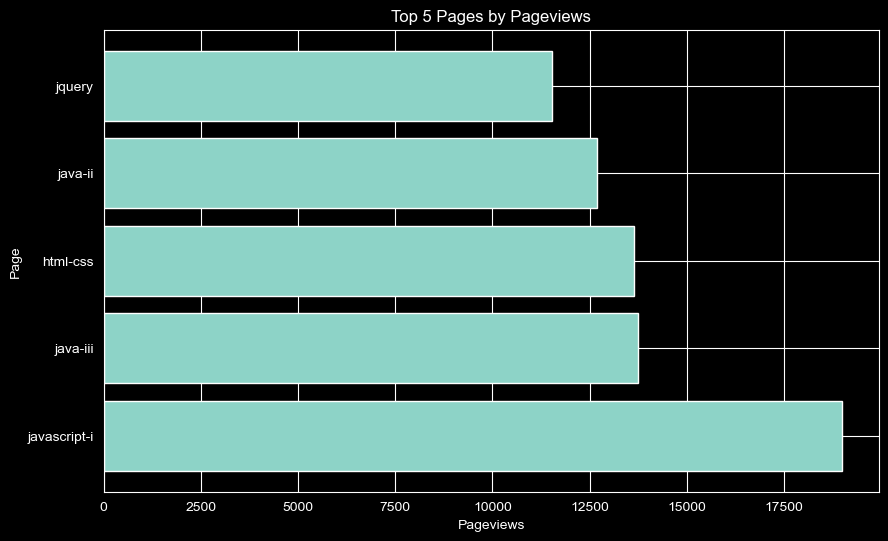

In [10]:
explore.plot_top_pages(df)

Top 5: Data Science Lesson Views
This bar chart shows the top 5 pages that attract the most traffic consistently. The most popular page appears to be "mysql", followed by "mysql/tables", and "mysqldatabase". There is a significant drop in traffic between the top page and the rest of the top 5. It is important to note that this analysis only considers the pages in the dataset, and may not reflect the entire website traffic.


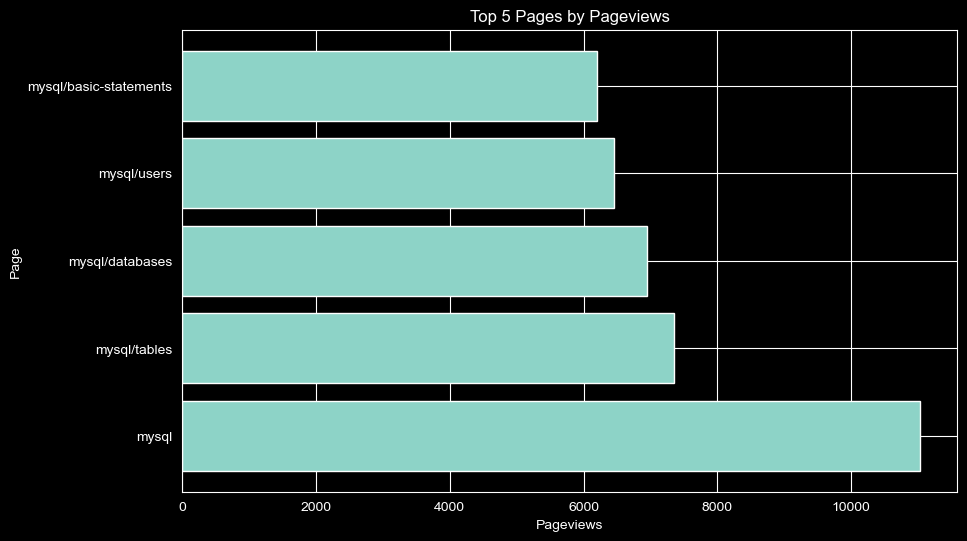

In [11]:
explore.ds_top_pages(df)

In [12]:
prepare.random_categories(df)

 This function, random_categories, generates random fish or animal names for each cohort_id based on their category. The function takes a DataFrame df as input and assigns random names from two different lists of animal and fish names to each cohort_id based on their category. If the category of the cohort is 'web_development', a random animal name is chosen from web_dev_animal_names list; otherwise, a random fish name is chosen from data_sci_fish_names list. For each cohort_id, the function creates a dictionary cohort_names and assigns a random name as a value for each key representing a cohort_id. Then it iterates through each row of the DataFrame and assigns the corresponding random name from the cohort_names dictionary to each row. Finally, the function returns the modified DataFrame with an additional column called nick_name, which contains the randomly assigned animal or fish name for each cohort_id.


,page,user_id,cohort_id,ip,datetime,time_spent,session_id,location,category,nick_name
0,/,1,8,97.105.19.61,2018-01-26 09:55:03,0.00,0,"Texas, United States",curriculum_infra,Shrimp
1,java-ii,1,8,97.105.19.61,2018-01-26 09:56:02,59.00,0,"Texas, United States",web_development,Weasel
2,java-ii/object-oriented-programming,1,8,97.105.19.61,2018-01-26 09:56:05,3.00,0,"Texas, United States",web_development,Elephant
3,slides/object_oriented_programming,1,8,97.105.19.61,2018-01-26 09:56:06,1.00,0,"Texas, United States",web_development,Leopard
4,javascript-i/conditionals,2,22,97.105.19.61,2018-01-26 09:56:24,18.00,0,"Texas, United States",web_development,Zebra
...,...,...,...,...,...,...,...,...,...,...
900218,jquery/personal-site,64,28,71.150.217.33,2021-04-21 16:41:51,0.00,8120,"Texas, United States",web_development,Orangutan
900219,jquery/mapbox-api,64,28,71.150.217.33,2021-04-21 16:42:02,11.00,8120,"Texas, United States",web_development,Moose
900220,jquery/ajax/weather-map,64,28,71.150.217.33,2021-04-21 16:42:09,7.00,8120,"Texas, United States",web_development,Elk
900221,anomaly-detection/discrete-probabilistic-methods,744,28,24.160.137.86,2021-04-21 16:44:37,148.00,8120,"Texas, United States",data_science,Sea Cucumber


In [13]:
df = explore.explore_prep(df)

Assigns random names to each cohort based on the category of that cohort. There are two lists of names: one for web development cohorts and the other for data science cohorts. For each row of the dataframe, a random name is chosen from the appropriate list based on the category of the cohort. This name is added to a dictionary cohort_names where the keys are cohort IDs and the values are the corresponding nicknames. The dataframe is merged with a new dataframe created from the cohort_names dictionary. The cohort_id column is used as the key for the merge. The 'nick_name_y' column is dropped and the 'nick_name_x' column is renamed to 'cohort'. A new column 'time_spent_zscore' is created which contains the z-score of the time spent by each row. A new column 'avg_time_spent_by_cohort' is created which contains the mean time spent on a page by a particular cohort. The cleaned dataframe is saved to a CSV file named 'prelim_clean.csv'.


In [14]:
df

,page,user_id,cohort_id,ip,datetime,time_spent,session_id,location,category,cohort,time_spent_zscore,avg_time_spent_by_cohort
0,/,1,8,97.105.19.61,2018-01-26 09:55:03,0.00,0,"Texas, United States",curriculum_infra,Sea Bass,-0.14,448.59
1,java-ii,1,8,97.105.19.61,2018-01-26 09:56:02,59.00,0,"Texas, United States",web_development,Skunk,-0.06,73.16
2,java-ii/object-oriented-programming,1,8,97.105.19.61,2018-01-26 09:56:05,3.00,0,"Texas, United States",web_development,Honey Badger,-0.13,44.57
3,slides/object_oriented_programming,1,8,97.105.19.61,2018-01-26 09:56:06,1.00,0,"Texas, United States",web_development,Leopard,-0.13,39.90
4,javascript-i/functions,1,8,97.105.19.61,2018-01-26 10:40:15,25.00,0,"Texas, United States",web_development,Chimpanzee,-0.11,88.42
...,...,...,...,...,...,...,...,...,...,...,...,...
900218,javascript-i/testing-user-functions,969,139,107.77.169.64,2021-04-21 12:13:18,1.00,8120,"Texas, United States",web_development,Hippopotamus,-0.13,82.44
900219,javascript-i,969,139,107.77.169.64,2021-04-21 12:31:48,92.00,8120,"Texas, United States",web_development,Hyena,-0.03,144.99
900220,javascript-i/javascript-with-html,969,139,107.77.169.64,2021-04-21 12:31:58,10.00,8120,"Texas, United States",web_development,Tiger,-0.12,94.96
900221,javascript-i/testing-user-functions,969,139,107.77.169.64,2021-04-21 12:32:01,3.00,8120,"Texas, United States",web_development,Coyote,-0.13,69.10


# 2. Is there a cohort that referred to a lesson significantly more than other cohorts?

In [15]:
explore.analyze_cohort(df)

Cohort 33 referred to page quiz significantly more than other cohorts


# 3. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?

In [16]:
explore.get_low_activity(df)

Low Activity Dataframe: The following table shows the user_id, cohort_id and count of students who have accessed the curriculum 10 times or less.


,user_id,cohort_id,count
68,62,0,4
75,66,13,1
80,71,19,5
86,77,7,10
90,81,18,3


# 4. Is there any suspicious activity, such as users/machines/etc accessing the curriculum who shouldn’t be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses?

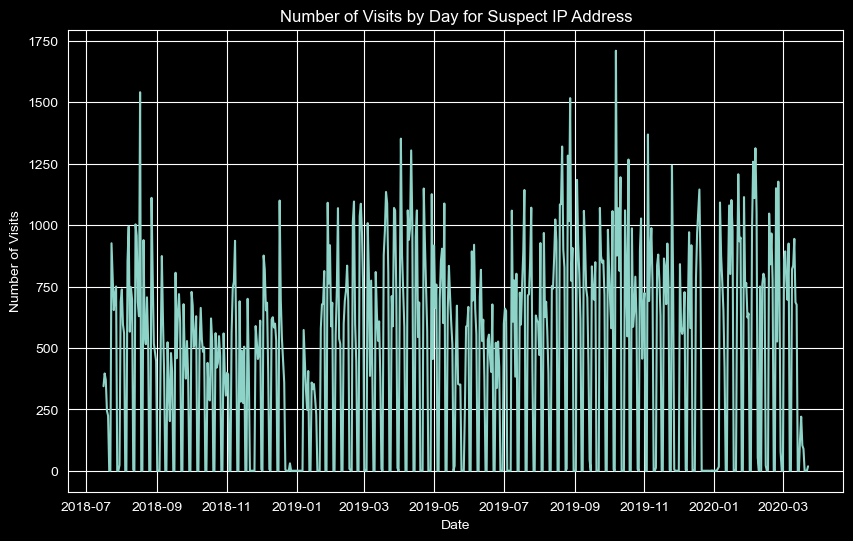

This function visualizes the number of visits per day for a specific IP address (97.105.19.58), which is suspected of engaging in suspicious activity on the website.


In [18]:
explore.suspect_IP(df)

# 5. At some point in 2019, the ability for students and alumni to access both curriculums (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before?

Access Log | User_ID 64: The code selects rows from the DataFrame where the user_id is equal to 64. It then converts the 'datetime' column to a datetime object, sets the 'datetime' column as the index, and resamples the data to show the count of pages accessed every 6 months. Finally, it plots the result as a line chart.The resulting plot will show the number of pages accessed by user_id 64 over time, with a new point every 6 months. The plot can be used to visualize the pattern of page access over time for this user.


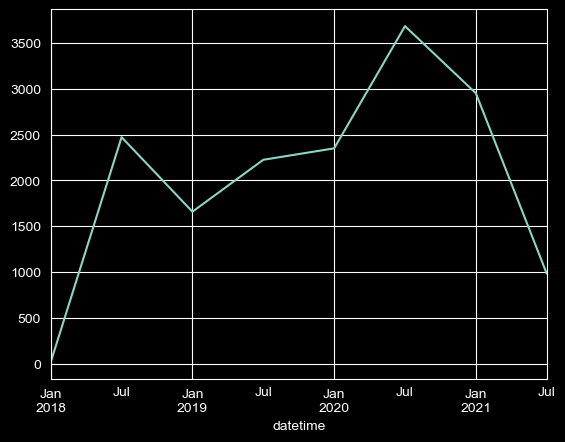

In [19]:
access_log = df[df['user_id'] == 64]
access_log['datetime'] = pd.to_datetime(access_log['datetime'])
access_log = access_log.set_index('datetime')
access_log.resample('6M')['page'].count().plot()
print("Access Log | User_ID 64: The code selects rows from the DataFrame where the user_id is equal to 64. It then converts the 'datetime' column to a datetime object, sets the 'datetime' column as the index, and resamples the data to show the count of pages accessed every 6 months. Finally, it plots the result as a line chart.The resulting plot will show the number of pages accessed by user_id 64 over time, with a new point every 6 months. The plot can be used to visualize the pattern of page access over time for this user.")

# 6. What topics are grads continuing to reference after graduation and into their jobs (for each program)?

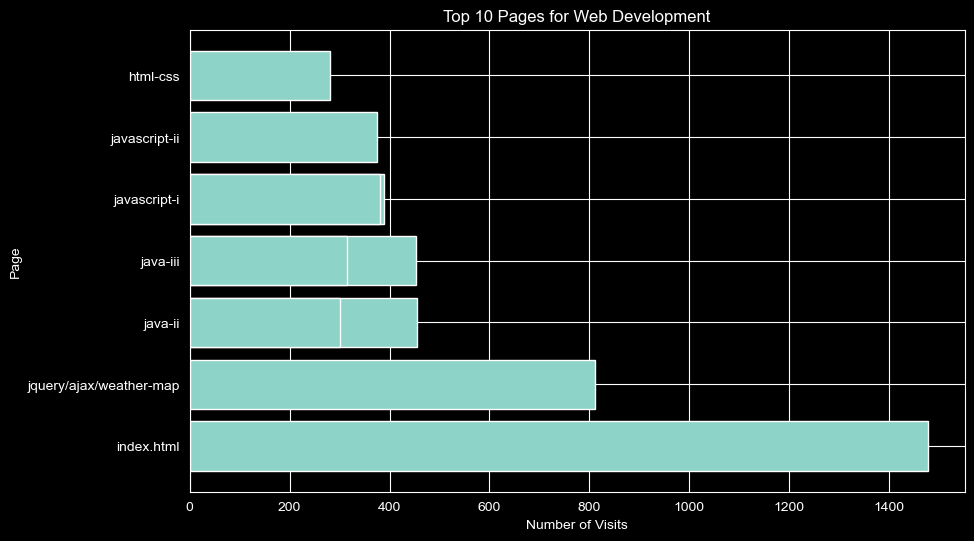

This visualization shows the top 10 pages visited by graduates in the Web Development program, based on the number of visits.


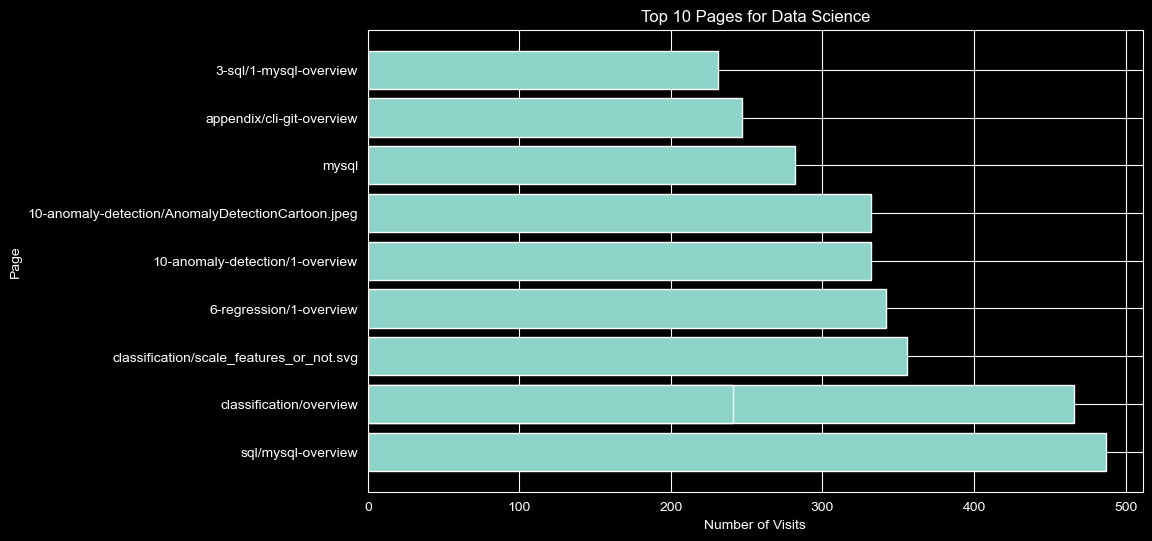

This visualization shows the top 10 pages visited by graduates in the Data Science program, based on the number of visits.


In [20]:
explore.favorite_learning_page(df)

# 7. Which lessons are least accessed?

The plot_top_least_accessed_pages() function plots the top and least accessed pages for each category.


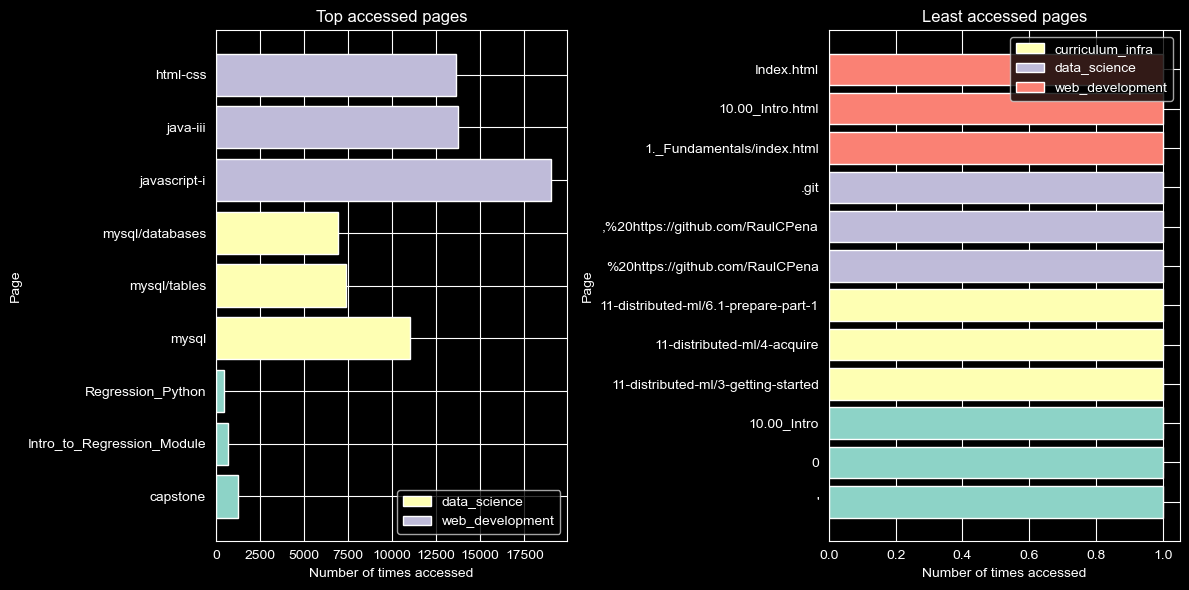

In [22]:
explore.plot_top_least_accessed_pages(df)

# 8. Anything else I should be aware of?

Visualize Suspicious Activity By Country: This function generates a horizontal bar chart that shows the number of page visits by country, excluding the United States. The purpose of this visualization is to increase understanding of the web traffic distribution of web traffic at CodeUp. The visualization filters out countries that visited the page only once and sorts the remaining countries by the number of page visits in descending order. This activity should be throughly investigted, but be warned that many anonymous/private people use Virtual Private Networks (VPN) to surf the interwebs.


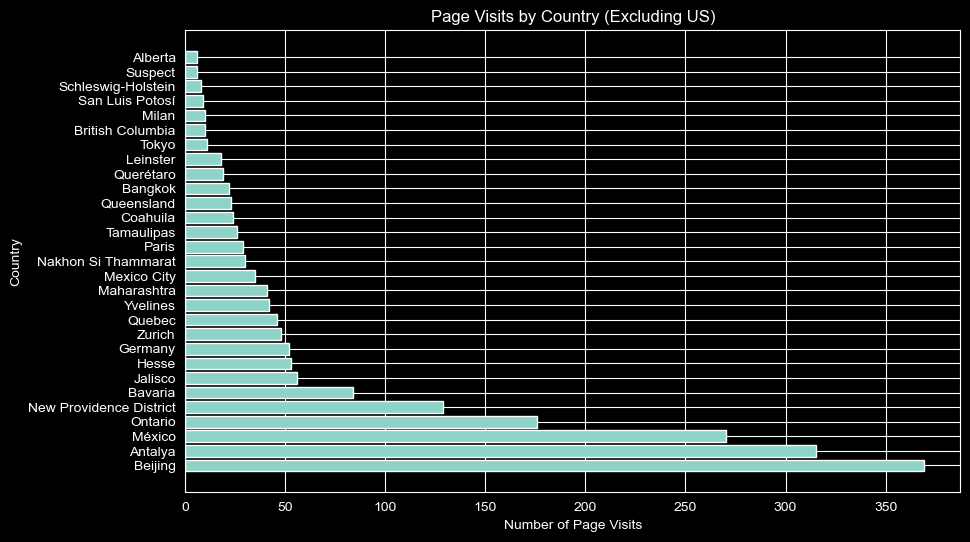

In [23]:
explore.visualize_visits_by_country(df)